In [2]:
import os
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 
import csv
import cv2
import data_aug
import importlib

from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import shutil


Run with trunk kernel

### PREPROCESSING DATA
Trim dataset for single image set to one x3, y3, z3 set per image. This contains the entire dataset

In [79]:
def make_rb_pos_csv(input_csv, output_csv):
    # Check if the output CSV exists and create it with the header if it doesn't
    if not os.path.exists(output_csv):
        header = ['ID', 'x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'isGripperOpen', 'img_filename']
        with open(output_csv, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(header)

    # Read the input CSV
    positions_df = pd.read_csv(input_csv)
    
    # Initialize variables to keep track of the last image filename and the last row to write
    last_img_filename = None
    last_output_row = None

    # Process each row in the input CSV
    for index, row in positions_df.iterrows():
        cur_img_filename = row['img_filename']
        #output_row = [row['ID'], row['x3'], row['y3'], row['z3'], cur_img_filename] #for tip position
        output_row = row

        # If the current image filename is different from the last, write the last output row
        if last_img_filename is not None and last_img_filename != cur_img_filename:
            with open(output_csv, 'a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow(last_output_row) 

        # Update the last image filename and last output row
        last_img_filename = cur_img_filename
        last_output_row = output_row
        #last_output_row_augmented = output_row_augmented

    # Write the last row (for the final image in the sequence)
    if last_output_row is not None:
        with open(output_csv, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(last_output_row)

In [80]:
data_dir = 'data/rigidbodies'
input_csv = os.path.join(data_dir, 'raw/single_img_regression.csv')  # replace with your actual CSV filename
output_csv = os.path.join(data_dir, 'single_img_regression_single_rb_pos.csv')
make_rb_pos_csv(input_csv, output_csv)

Plot tip position overlaid on images to verify dataset quality

In [3]:
def convert_to_pillow_coords(df, img_width, img_height, x_min, x_max, z_min, z_max):
    """
    Convert robot coordinates to Pillow image coordinates.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'x' and 'z' columns in robot coordinates.
    img_width, img_height (int): Dimensions of the Pillow image.

    Returns:
    pd.DataFrame: DataFrame with 'img_x' and 'img_y' columns for Pillow image coordinates.
    """

    # Calculate the scaling factors for x and z coordinates
    x_scale = img_width / (x_max - x_min)
    z_scale = img_height / (z_max - z_min)

    # Calculate the shifts to center the robot's origin within the image
    x_shift = (x_max + x_min) / 2
    z_shift = (z_max + z_min) / 2

    # Convert robot coordinates to Pillow image coordinates
    df['img_x'] = (df['x'] - x_shift) * x_scale + img_width / 2
    df['img_y'] = (df['z'] - z_shift) * z_scale + img_height / 2

    # Invert the y-axis and x-axis to match Pillow's coordinate system (where (0, 0) is top-left)
    df['img_y'] = img_height - df['img_y']
    df['img_x'] = img_width - df['img_x']

    return df[['img_x', 'img_y']]



In [16]:
def plot_predictions_on_images(results, data_dir, output_folder, dataset_file):
    """
    Plot ground truth and predicted tip positions on images.

    Parameters:
    results (list): List of dictionaries containing img_filename, true_x, true_z, pred_x, pred_z
    data_dir (str): Directory containing the images.
    """
    image_folder = os.path.join(data_dir, 'raw/images')

    for result in results:
        image_filename = result['img_filename']
        image_path = os.path.join(image_folder, image_filename)

        # Open the image
        with Image.open(image_path) as img:
            img_width, img_height = img.size

            # Convert ground truth and predicted coordinates to image coordinates
            positions_df = pd.read_csv(dataset_file)


            # Convert entire DataFrame coordinates to Pillow image coordinates once
            overall_df = positions_df[['x3', 'z3']].rename(columns={'x3': 'x', 'z3': 'z'})

            #calculate extent of dataset for scaling to pillow coords
            x_min, x_max = overall_df['x'].min() - 0.01, overall_df['x'].max() + 0.01
            z_min, z_max = overall_df['z'].min() - 0.01, overall_df['z'].max() + 0.01

            true_img_coords = convert_to_pillow_coords(pd.DataFrame({'x': [result['true_x']], 'z': [result['true_z']]}), img_width, img_height, x_min, x_max, z_min, z_max)
            pred_img_coords = convert_to_pillow_coords(pd.DataFrame({'x': [result['pred_x']], 'z': [result['pred_z']]}), img_width, img_height,  x_min, x_max, z_min, z_max)

            # Create a figure with the same dimensions as the image
            fig, ax = plt.subplots(figsize=(img_width / 100, img_height / 100), dpi=100)

            # Plot the image
            ax.imshow(img)

            # Plot the ground truth tip position
            ax.scatter([true_img_coords['img_x'][0]], [true_img_coords['img_y'][0]], color='green', s=200, label='Ground Truth')

            # Plot the predicted tip position
            ax.scatter([pred_img_coords['img_x'][0]], [pred_img_coords['img_y'][0]], color='red', s=200, label='Prediction')

            # Remove axes for a cleaner output
            ax.axis('off')

            # Add a legend
            ax.legend()

            # Save the image with the original dimensions
            output_filename = os.path.join(data_dir, f"model_validation/{output_folder}/output_{image_filename}")
            plt.savefig(output_filename, bbox_inches='tight', pad_inches=0)
            plt.close(fig)

            print(f"Plotted ground truth and prediction on {image_filename} and saved as {output_filename}.")


Train-val-test split

Create new csvs for train, val, and test

In [83]:
input_dir = 'data/rigidbodies'
output_dir = 'data/rigidbodies/split'
os.makedirs(output_dir, exist_ok=True)
csv_file = os.path.join(input_dir, 'single_img_regression_single_rb_pos.csv')
image_dir = os.path.join(input_dir, 'raw/images')

# Load the original CSV file
df = pd.read_csv(csv_file)

# Split the data (80-10-10)
train_filenames, test_filenames = train_test_split(df['img_filename'].tolist(), test_size=0.1, random_state=42)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.12, random_state=42) # 0.12 * 0.9 = 0.1

# Filter the original DataFrame to create train, validation, and test CSVs
train_df = df[df['img_filename'].isin(train_filenames)]
val_df = df[df['img_filename'].isin(val_filenames)]
test_df = df[df['img_filename'].isin(test_filenames)]

# Save the new CSVs
train_csv_path = os.path.join(output_dir, 'train.csv')
val_csv_path = os.path.join(output_dir, 'val.csv')
test_csv_path = os.path.join(output_dir, 'test.csv')

train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

Augment images and update train.csv

In [85]:
# Ensure output directories exist
test_dir = os.path.join(output_dir, 'images/test')
val_dir = os.path.join(output_dir, 'images/val')
train_dir = os.path.join(output_dir, "images/train")
os.makedirs(test_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)

importlib.reload(data_aug)

# Augment the training images and update the CSV
augmented_rows = []
for filename in train_filenames:
    image_path = os.path.join(image_dir, filename)
    augmented_filename = data_aug.augment_image(image_path, train_dir)
    
    # Add the new row for the augmented image to the augmented_rows list
    new_row = train_df[train_df['img_filename'] == filename].copy()
    new_row['img_filename'] = augmented_filename
    augmented_rows.append(new_row)

# Create a new DataFrame for the augmented data and append to train_df
augmented_df = pd.concat(augmented_rows)
final_train_df = pd.concat([train_df, augmented_df])

# Save the updated train CSV
final_train_df.to_csv(train_csv_path, index=False)

# Copy validation and test images and CSVs without augmentation
for filename in val_filenames:
    src_path = os.path.join(image_dir, filename)
    data_aug.crop_and_resize(src_path, val_dir)

for filename in test_filenames:
    src_path = os.path.join(image_dir, filename)
    data_aug.crop_and_resize(src_path, test_dir)

### TRAINING THE MODEL

1. Load the Dataset

In [10]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx]['img_filename'])  # Use column name
        image = Image.open(img_name).convert("RGB")
        labels = self.data_frame.iloc[idx, 1:10].values
        labels = labels.astype('float').tolist()

        if self.transform:
            image = self.transform(image)

        # Return image, labels, and the image filename
        return image, torch.tensor(labels), self.data_frame.iloc[idx]['img_filename']  # Use column name


# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)), # image input size to model (224,224)
    # out of memory error with 1080x1080, batch size 32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Function to calculate RMSE
criterion = nn.MSELoss()
def calculate_rmse(outputs, labels):
    mse_loss = criterion(outputs, labels)
    return torch.sqrt(mse_loss).item()

# Dataset parameters
data_dir = 'data/rigidbodies/split' #just change this when you change datasets

train_csv_file = os.path.join(data_dir, 'train.csv')
train_img_dir = os.path.join(data_dir, 'images/train')

val_csv_file = os.path.join(data_dir, 'val.csv')
val_img_dir = os.path.join(data_dir, 'images/val')

test_csv_file = os.path.join(data_dir, 'test.csv')
test_img_dir = os.path.join(data_dir, 'images/test')


# Load datasets
train_dataset = ImageDataset(csv_file=train_csv_file, root_dir=train_img_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ImageDataset(csv_file=val_csv_file, root_dir=val_img_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

test_dataset = ImageDataset(csv_file=test_csv_file, root_dir=test_img_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


2. Define the Model

Check CUDA available (should be on ceres)

In [11]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [12]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)

# Replace the last fully connected layer to output 9 values (x1, y1, z1, x2, y2, z2, x3, y3, z3)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9) #output layers is 9-vector

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Running on device: {device}")

/home/markleone/miniconda3/envs/trunk/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/markleone/miniconda3/envs/trunk/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Running on device: cuda:0


3. Train the model

Epoch [1/200], Loss: 0.3826, Train RMSE: 0.6036, Val RMSE: 0.7679
Epoch [2/200], Loss: 0.0890, Train RMSE: 0.2795, Val RMSE: 0.9371
Epoch [3/200], Loss: 0.0128, Train RMSE: 0.1129, Val RMSE: 1.1930
Epoch [4/200], Loss: 0.0047, Train RMSE: 0.0687, Val RMSE: 1.4599
Epoch [5/200], Loss: 0.0037, Train RMSE: 0.0605, Val RMSE: 1.4165
Epoch [6/200], Loss: 0.0026, Train RMSE: 0.0505, Val RMSE: 1.2237
Epoch [7/200], Loss: 0.0022, Train RMSE: 0.0471, Val RMSE: 1.0691
Epoch [8/200], Loss: 0.0015, Train RMSE: 0.0387, Val RMSE: 0.9501
Epoch [9/200], Loss: 0.0016, Train RMSE: 0.0396, Val RMSE: 0.8161
Epoch [10/200], Loss: 0.0012, Train RMSE: 0.0348, Val RMSE: 0.7119
Epoch [11/200], Loss: 0.0010, Train RMSE: 0.0313, Val RMSE: 0.6212
Epoch [12/200], Loss: 0.0006, Train RMSE: 0.0255, Val RMSE: 0.5116
Epoch [13/200], Loss: 0.0008, Train RMSE: 0.0289, Val RMSE: 0.4142
Epoch [14/200], Loss: 0.0006, Train RMSE: 0.0247, Val RMSE: 0.3569
Epoch [15/200], Loss: 0.0005, Train RMSE: 0.0227, Val RMSE: 0.3260
Epoc

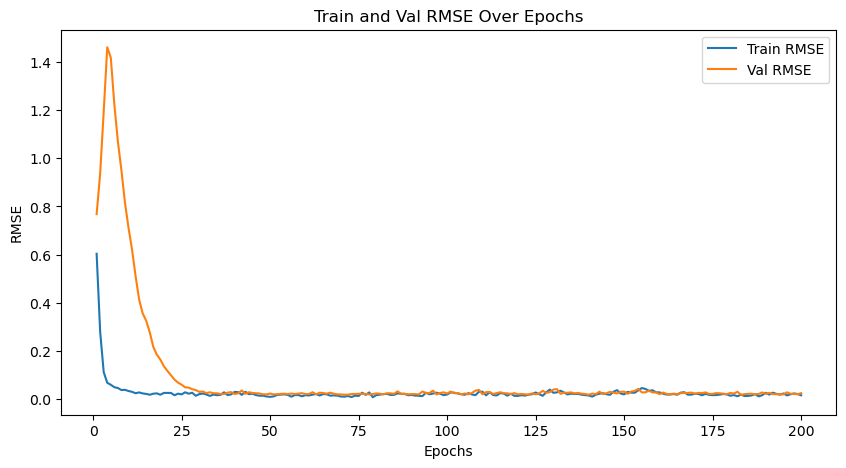

In [94]:
# define checkpoint path
checkpoint_dir = os.path.join(data_dir, 'checkpoint')
os.makedirs(checkpoint_dir, exist_ok=True)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with accuracy tracking and checkpoint saving
num_epochs = 200
checkpoint_interval = 50  # Save checkpoint every 'n' epochs

train_rmse_history = []
val_rmse_history = []

best_val_rmse = float('inf')  # Initialize best validation RMSE to a large value

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_rmse = 0.0
    for inputs, labels, _ in train_loader:  # Assuming train_loader is your training DataLoader
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Calculate RMSE for this batch
        train_rmse += calculate_rmse(outputs, labels)

        # Update running loss
        running_loss += loss.item()

    train_rmse /= len(train_loader)  # Average RMSE for the epoch
    train_rmse_history.append(train_rmse)

    # Validation phase
    model.eval()
    val_rmse = 0.0
    with torch.no_grad():
        for inputs, labels, _ in val_loader:  # Assuming val_loader is your validation DataLoader
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_rmse += calculate_rmse(outputs, labels)

    val_rmse /= len(val_loader)  # Average RMSE for the epoch
    val_rmse_history.append(val_rmse)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}')

    # Save checkpoint if it is a checkpoint interval or the last epoch
    if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
        checkpoint_file = f'model_checkpoint_epoch_{epoch+1}.pth'
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_file)
        torch.save(model.state_dict(), checkpoint_path)
        #print(f'Saved checkpoint: {checkpoint_path}')

    # Track the best validation RMSE and save the best model
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        #print(f'Best model saved with Val RMSE: {best_val_rmse:.4f}')

print('Finished Training')
print(f'Best model saved with Val RMSE: {best_val_rmse:.4f}')

# Plot training and validation RMSE over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_rmse_history, label='Train RMSE')
plt.plot(range(1, num_epochs + 1), val_rmse_history, label='Val RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train and Val RMSE Over Epochs')
plt.legend()
plt.show()

# for 224x224 3-vector/9-vector and 30-img dataset, 200 epochs (10x faster on gpu than my mac, 5 min on GPU)...  barely depends on output dimension

4. Evaluate the model on val set

In [13]:
checkpoint_dir = os.path.join(data_dir, 'checkpoint')
best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')

model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode


# testin on training set (should be able to memorize training data as a first step)
val_rmse = 0.0
with torch.no_grad():
    for i in range(len(val_dataset)):  # Test on the first 5 images
        inputs, labels, _ = val_dataset[i]
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        labels = labels.unsqueeze(0).to(device)
        outputs = model(inputs)
        val_rmse += calculate_rmse(outputs, labels)
        print(f'Predicted: {outputs.cpu().numpy()}, Ground Truth: {labels.cpu().numpy()}')
val_rmse /= len(val_dataset)
print(f'Val RMSE = {val_rmse}')

Predicted: [[ 0.02489684 -0.10602148 -0.00076691  0.00839859 -0.19768363 -0.06827059
  -0.02412415 -0.18339644 -0.1581826 ]], Ground Truth: [[-0.00024152 -0.10676479 -0.00238466 -0.00191188 -0.19126058 -0.05134499
  -0.00449705 -0.18612087 -0.16756463]]
Predicted: [[-0.01112173 -0.09439871  0.00373723  0.03161096 -0.17753646 -0.06774747
   0.11502889 -0.15762372 -0.09282959]], Ground Truth: [[ 0.00327134 -0.10675478 -0.00221789  0.05606925 -0.17359805 -0.05000675
   0.14250076 -0.15366375 -0.12532175]]
Predicted: [[-0.00497432 -0.10046997  0.00487539 -0.03392935 -0.18975706 -0.03163688
  -0.11910074 -0.16949762 -0.05346945]], Ground Truth: [[-0.00628877 -0.10679579 -0.00216877 -0.0756228  -0.17149305 -0.02554584
  -0.18571019 -0.1668675  -0.0629555 ]]
Predicted: [[-0.00239276 -0.09573945  0.00636625  0.08106974 -0.17225003 -0.02956617
   0.20445515 -0.15645102 -0.05284077]], Ground Truth: [[ 0.00621653 -0.10673285 -0.00238931  0.07821894 -0.16644025 -0.03049803
   0.18591416 -0.1524612

5. Test model on test set

In [14]:
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode

# testin on training set (should be able to memorize training data as a first step)
test_rmse = 0.0
with torch.no_grad():
    for i in range(len(test_dataset)):  # Test on the first 5 images
        inputs, labels, _ = test_dataset[i]
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        labels = labels.unsqueeze(0).to(device)
        outputs = model(inputs)
        test_rmse += calculate_rmse(outputs, labels)
        print(f'Predicted: {outputs.cpu().numpy()}, Ground Truth: {labels.cpu().numpy()}')
test_rmse /= len(test_dataset)
print(f'Test RMSE = {test_rmse}')

Predicted: [[-0.00668268 -0.10205215  0.00389377 -0.04078171 -0.1898047  -0.03928579
  -0.11376605 -0.20404935 -0.09640968]], Ground Truth: [[-0.00239074 -0.10685873 -0.00206006 -0.05263531 -0.17902851 -0.04456234
  -0.14287937 -0.18164945 -0.11797392]]
Predicted: [[-0.00723765 -0.09880755  0.00536145 -0.05370172 -0.20343739 -0.0017317
  -0.1598483  -0.21731584  0.01919955]], Ground Truth: [[-0.00903451 -0.1069802   0.00124073 -0.07653177 -0.17712235  0.00921786
  -0.1891582  -0.20365357  0.02152622]]
Predicted: [[-0.00645772 -0.09399348  0.00414283 -0.04135388 -0.18793972 -0.05670231
  -0.094463   -0.18301703 -0.12388094]], Ground Truth: [[-0.00163829 -0.10683978 -0.00211477 -0.0343343  -0.18846679 -0.0446285
  -0.10292017 -0.19354498 -0.13849175]]
Predicted: [[-0.00264093 -0.09343958  0.00406022  0.08046491 -0.17587507 -0.02939214
   0.19782424 -0.1733585  -0.05403538]], Ground Truth: [[ 0.00498879 -0.10690939 -0.00256503  0.05721009 -0.18488693 -0.02961791
   0.15931404 -0.20022917 

Display gt vs predicted tip positions on image

For val dataset

In [18]:
# Load the best model weights
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode

# Placeholder for collecting results
results = []

with torch.no_grad():
    for i in range(len(val_dataset)):
        inputs, labels, img_filename = val_dataset[i]
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        labels = labels.unsqueeze(0).to(device)
        #print(labels)
        outputs = model(inputs)

        # Collect the ground truth and predictions
        results.append({
            'img_filename': img_filename, 
            'true_x': labels[0, 6].item(), #x3
            'true_z': labels[0, 8].item(), #z3
            'pred_x': outputs[0, 6].item(), #x3
            'pred_z': outputs[0, 8].item() #z3
        })
    print(results)

data_dir = 'data/rigidbodies'
output_folder = 'val'
dataset_file = os.path.join(data_dir, 'single_img_regression_single_rb_pos.csv')
plot_predictions_on_images(results, data_dir, output_folder, dataset_file)


[{'img_filename': 'sample_2.jpg', 'true_x': -0.004497051239013672, 'true_z': -0.16756463050842285, 'pred_x': -0.0241241455078125, 'pred_z': -0.15818260610103607}, {'img_filename': 'sample_5.jpg', 'true_x': 0.14250075817108154, 'true_z': -0.12532174587249756, 'pred_x': 0.11502888798713684, 'pred_z': -0.09282958507537842}, {'img_filename': 'sample_7.jpg', 'true_x': -0.18571019172668457, 'true_z': -0.06295549869537354, 'pred_x': -0.11910074204206467, 'pred_z': -0.0534694530069828}, {'img_filename': 'sample_13.jpg', 'true_x': 0.18591415882110596, 'true_z': -0.0722883939743042, 'pred_x': 0.2044551521539688, 'pred_z': -0.052840765565633774}]
Plotted ground truth and prediction on sample_2.jpg and saved as data/rigidbodies/model_validation/val/output_sample_2.jpg.
Plotted ground truth and prediction on sample_5.jpg and saved as data/rigidbodies/model_validation/val/output_sample_5.jpg.
Plotted ground truth and prediction on sample_7.jpg and saved as data/rigidbodies/model_validation/val/outpu

For test dataset

In [20]:
# Load the best model weights
model.load_state_dict(torch.load(best_model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode

# Placeholder for collecting results
results = []

with torch.no_grad():
    for i in range(len(test_dataset)):
        inputs, labels, img_filename = test_dataset[i]
        inputs = inputs.unsqueeze(0).to(device)  # Add batch dimension and move to GPU
        labels = labels.unsqueeze(0).to(device)
        #print(labels)
        outputs = model(inputs)

        # Collect the ground truth and predictions
        results.append({
            'img_filename': img_filename, 
            'true_x': labels[0, 6].item(),
            'true_z': labels[0, 8].item(),
            'pred_x': outputs[0, 6].item(),
            'pred_z': outputs[0, 8].item()
        })
    print(results)


data_dir = 'data/rigidbodies'
output_folder = 'test'
dataset_file = os.path.join(data_dir, 'single_img_regression_single_rb_pos.csv')
plot_predictions_on_images(results, data_dir, output_folder, dataset_file)


[{'img_filename': 'sample_15.jpg', 'true_x': -0.14287936687469482, 'true_z': -0.1179739236831665, 'pred_x': -0.11376605182886124, 'pred_z': -0.09640967845916748}, {'img_filename': 'sample_17.jpg', 'true_x': -0.18915820121765137, 'true_z': 0.021526217460632324, 'pred_x': -0.15984830260276794, 'pred_z': 0.01919955015182495}, {'img_filename': 'sample_23.jpg', 'true_x': -0.10292017459869385, 'true_z': -0.13849174976348877, 'pred_x': -0.09446299821138382, 'pred_z': -0.12388093769550323}, {'img_filename': 'sample_27.jpg', 'true_x': 0.15931403636932373, 'true_z': -0.08327913284301758, 'pred_x': 0.19782423973083496, 'pred_z': -0.054035384207963943}]
Plotted ground truth and prediction on sample_15.jpg and saved as data/rigidbodies/model_validation/test/output_sample_15.jpg.
Plotted ground truth and prediction on sample_17.jpg and saved as data/rigidbodies/model_validation/test/output_sample_17.jpg.
Plotted ground truth and prediction on sample_23.jpg and saved as data/rigidbodies/model_validat

In [29]:
import torch
import time
from math import floor

# Assume `model` is your already trained model

# Single image tensor (assuming it is already preprocessed)
input_image = torch.randn(1, 3, 224, 224)  # Batch size of 1, 3 channels (RGB), 224x224 resolution

# Ensure that the model is correctly loaded on the CPU
model_cpu = model.to('cpu')
model_cpu.eval()

# Measure inference time on CPU
input_image_cpu = input_image.to('cpu')  # Ensure the input tensor is on the CPU
with torch.no_grad():
    start_time = time.time()
    for _ in range(100):  # Run inference 100 times to get an average
        _ = model_cpu(input_image_cpu)
    end_time = time.time()
    avg_cpu_time = (end_time - start_time) / 100
    print(f'Average inference time on CPU: {avg_cpu_time:.6f} seconds')

# Measure inference time on GPU (if available)
if torch.cuda.is_available():
    model_gpu = model.to('cuda')
    model_gpu.eval()
    input_image_gpu = input_image.to('cuda')  # Ensure the input tensor is on the GPU

    with torch.no_grad():
        # Warm-up GPU (GPU needs a warm-up time for the first operation)
        _ = model_gpu(input_image_gpu)

        start_time = time.time()
        for _ in range(100):  # Run inference 100 times to get an average
            _ = model_gpu(input_image_gpu)
        # Wait for GPU to finish (synchronize)
        torch.cuda.synchronize()
        end_time = time.time()
        avg_gpu_time = (end_time - start_time) / 100
        print(f'Average inference time on GPU: {avg_gpu_time:.6f} seconds')

cpu_over_gpu = avg_cpu_time / avg_gpu_time
print(f'gpu is {int(cpu_over_gpu)} times faster than cpu')

cpu_hz = 1/avg_cpu_time
gpu_hz = 1/avg_gpu_time
print(f'cpu max inference rate = {floor(cpu_hz)} Hz')
print(f'gpu max inference rate = {floor(gpu_hz)} Hz')

# on ceres:
# Average inference time on CPU: 0.035125 seconds
# Average inference time on GPU: 0.002542 seconds
# gpu is 13 times faster than cpu
# cpu max inference rate = 28 Hz
# gpu max inference rate = 393 Hz
# but this varies from call to call


Average inference time on CPU: 0.035125 seconds
Average inference time on GPU: 0.002542 seconds
gpu is 13 times faster than cpu
cpu max inference rate = 28 Hz
gpu max inference rate = 393 Hz
